# MEFISTO application to longitudinal microbiome data

This notebook demonstrates how longitudinal data can be analysed with MEFISTO.

Please find more information about this method [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

An R version of the tutorial is available [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/microbiome_tutorial.html).

The data for this notebook can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6). The following files are used in this tutorial:

- `microbiome_data.csv` containing the microbiome data used as input,
- `microbiome_features_metadata.csv` containing taxonomic information for the features in the model,
- `microbiome_model.hdf5` containing the pre-trained MEFISTO model.

The original data was published by [Bokulich et al.](https://stm.sciencemag.org/content/8/343/343ra82).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mofapy2.run.entry_point import entry_point
import mofax

## Load data

In this notebook, we put the files into the `data/microbiome/` directory.

We first load the dataframe that contains the preprocessed microbiome data for all children (groups) as well as the time annotation (month of life) for each sample.

In [3]:
datadir = "data/microbiome/"

In [4]:
microbiome = pd.read_csv(f"{datadir}/microbiome_data.csv")
microbiome.head()

,group,month,feature,value,view,sample,delivery,diet,sex
0,C001,0,ac5402de1ddf427ab8d2b0a8a0a44f19,0.616022,microbiome,C001_0,Vaginal,bd,Female
1,C001,0,2a2947125c677c6e27898ad4e9b9dca7,NaN,microbiome,C001_0,Vaginal,bd,Female
2,C001,0,0cc2420a6a4698f8bf664d50b17d26b4,NaN,microbiome,C001_0,Vaginal,bd,Female
3,C001,0,651794369aeb3db83839b81fe49c8b4e,NaN,microbiome,C001_0,Vaginal,bd,Female
4,C001,0,e6a34eb113dba66df0b8bbec907a8f5d,-0.416379,microbiome,C001_0,Vaginal,bd,Female


In [5]:
feature_meta = pd.read_csv(f"{datadir}/microbiome_features_metadata.csv")
feature_meta.head()

,SampleID,Taxon,Confidence
0,ac5402de1ddf427ab8d2b0a8a0a44f19,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999770
1,2a2947125c677c6e27898ad4e9b9dca7,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000
2,0cc2420a6a4698f8bf664d50b17d26b4,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.968037
3,3d9838f12f6ff5591dbadeb427a855f1,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.859635
4,651794369aeb3db83839b81fe49c8b4e,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.995550


## Prepare and train MEFISTO

Create the MOFA object

First, we need to create a MOFA object from this data. This step is analogous to use of MOFA without the time information and can be done using create_mofa, which results in an untrained MOFA object.

In [6]:
ent = entry_point()
ent.set_data_options(center_groups=False)
ent.set_data_df(microbiome)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='C001' view='microbiome' with N=24 samples and D=969 features...
Loaded group='C002' view='microbiome' with N=24 samples and D=969 features...
Loaded group='C004' view='microbiome' with N=24 samples and D=969 features...
Loaded group='C005' view='microbiome' with N=24 samples and D=969 features...
Loaded group='C007' view='microbiome' with N=24 samples and D=969 f

In [7]:
microbiome_groups = [microbiome.loc[microbiome.group == group,["sample", "group", "month"]].drop_duplicates().set_index("sample") for group in ent.data_opts["groups_names"]]
ent.data_opts["samples_metadata"] = microbiome_groups

Next, we want to add the time information for each sample, which we can do using `set_covariates`. As the information on the month for each sample is already contained in the data that we passed to the `entry_point` above, we can just specify to use this column as a covariate. Alternatively, we could also supply a new matrix or data frame providing the sample names and covariates.

In [8]:
ent.set_covariates("month", covariates_names="month")

Loaded 1 covariate(s) for each sample...




We now need to provide model and train options:

In [9]:
ent.set_model_options(factors=2)
ent.set_train_options(seed=2020)
ent.set_smooth_options(n_grid=10, start_opt=50, opt_freq=50)


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (microbiome): gaussian




Now we are ready to use MEFISTO with this object and save the results in a specified location. As this can take some time, we provide a pre-trained model below.

In [10]:
ent.build()
# ent.run()
# ent.save(f"microbiome_model.hdf5")

## Downstream analysis

For downstream analysis we can either use R (package [MOFA2](https://github.com/bioFAM/MOFA2)) or the Python package [mofax](https://github.com/bioFAM/mofax). Here we will proceed in Python and first load the pre-trained model generated by the above steps.

In [11]:
m = mofax.mofa_model(f"{datadir}/microbiome_model.hdf5")
m

MOFA+ model: microbiome model
Samples (cells): 1032
Features: 969
Groups: C001 (24), C002 (24), C004 (24), C005 (24), C007 (24), C008 (24), C009 (24), C010 (24), C011 (24), C012 (24), C014 (24), C016 (24), C017 (24), C018 (24), C020 (24), C021 (24), C022 (24), C023 (24), C024 (24), C025 (24), C027 (24), C030 (24), C031 (24), C032 (24), C033 (24), C034 (24), C035 (24), C036 (24), C037 (24), C038 (24), C041 (24), C042 (24), C043 (24), C044 (24), C045 (24), C046 (24), C047 (24), C049 (24), C052 (24), C053 (24), C055 (24), C056 (24), C057 (24)
Views: microbiome (969)
Factors: 2
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: month
Interpolated factors for 24 new values

In the case of using the pre-trained model with missing metadata, we might need to add it:

In [12]:
m.samples_metadata = (m.covariates.set_index(["group", "month"], 
                                             append=True).merge(
    microbiome.loc[:,["sample", "group", "month", "delivery", "diet", "sex"]].drop_duplicates(), 
    on=["sample", "group", "month"],
    sort=False)
).set_index("sample")
m.samples_metadata.head()

,group,month,month_transformed,delivery,diet,sex
sample,,,,,,
C001_0,C001,0.0,0.0,Vaginal,bd,Female
C001_1,C001,1.0,1.0,Vaginal,bd,Female
C001_2,C001,2.0,2.0,Vaginal,bd,Female
C001_3,C001,3.0,3.0,Vaginal,bd,Female
C001_4,C001,4.0,4.0,Vaginal,bd,Female


In [13]:
feature_meta[["kingdom", "phylum", "class", "order", "family", "genus", "species"]] = feature_meta.Taxon.str.split("; ", expand=True)

In [14]:
m.features_metadata = (
    m.features_metadata.merge(
        feature_meta
            .rename(columns={"SampleID": "feature"}), 
        on="feature", sort=False).set_index("feature")
)
m.features_metadata.head()

,view,Taxon,Confidence,kingdom,phylum,class,order,family,genus,species
feature,,,,,,,,,,
ac5402de1ddf427ab8d2b0a8a0a44f19,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999770,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__
2a2947125c677c6e27898ad4e9b9dca7,microbiome,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Tissierellaceae],g__WAL_1855D,s__
0cc2420a6a4698f8bf664d50b17d26b4,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.968037,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__onderdonkii
651794369aeb3db83839b81fe49c8b4e,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.995550,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__
e6a34eb113dba66df0b8bbec907a8f5d,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.974159,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__putredinis


## Factor overview and visualization

### Variance decomposition and factor correlation

To obtain a first overview of the factors we can take a look at the variance that a factor explains in each child.

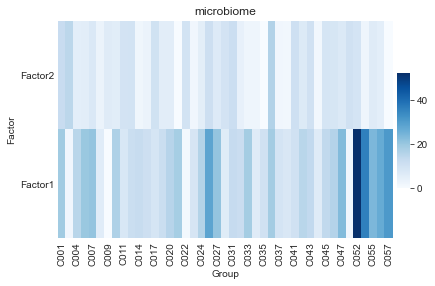

In [15]:
mofax.plot_r2(m, cmap="Blues")

### Factors versus month of life

To investigate the inferred factors, we can plot them against the months of life and colour them by the metadata of the samples. Here, we color by delivery mode and diet.

Using the first two factors, we can project the samples into a 2-dimensional space.

In [16]:
cols4diet = {"fd": "#1f78b4", "bd": "#b2df8a"}
cols4delivery = {"Cesarean": "#e6ab02", "Vaginal": "#d95f02"}

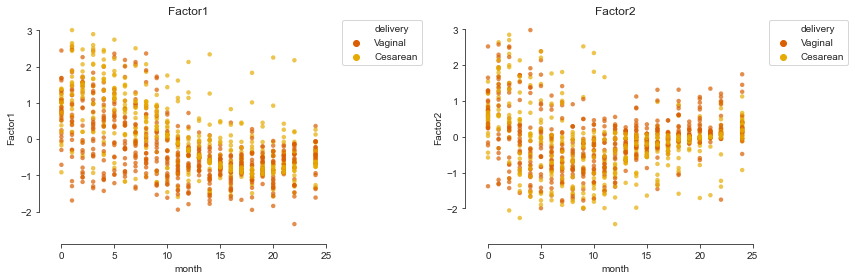

In [17]:
mofax.plot_factors(m, x="month", y=[0, 1], 
                   color="delivery", palette=cols4delivery, alpha=.7);

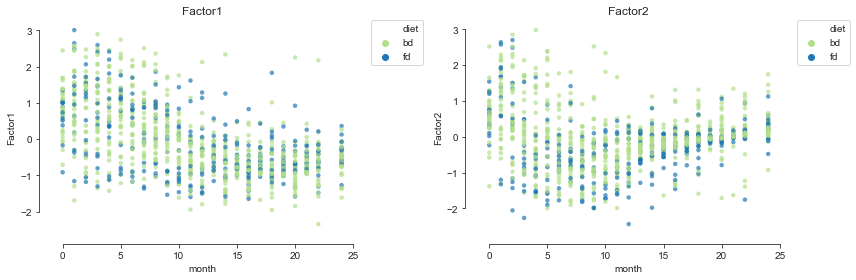

In [18]:
mofax.plot_factors(m, x="month", y=[0, 1], 
                   color="diet", palette=cols4diet, alpha=.7);

### Interpolation

Using the underlying Gaussian process for each factor we can interpolate to unseen time points for children that are missing data in these time points and intermediate time points.

We will plot values for the first 5 children:

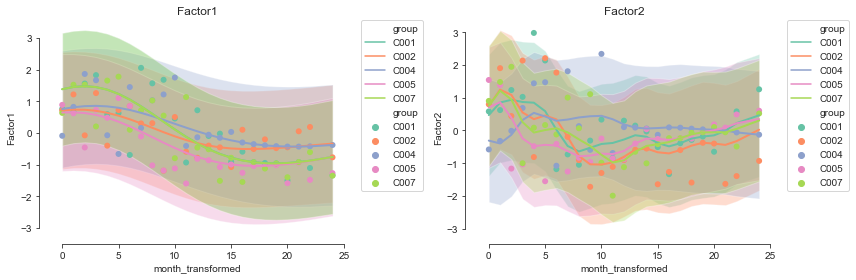

In [19]:
mofax.plot_interpolated_factors(m, groups=m.groups[:5], factors=range(m.nfactors), size=70);

Uncertainties and observed data points on these plots can be hidden with `only_mean=True` and `show_observed=False`:

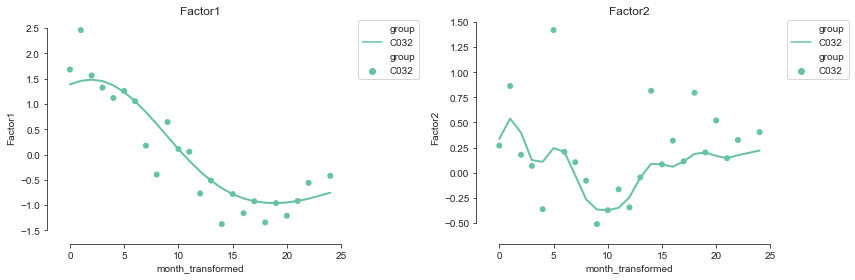

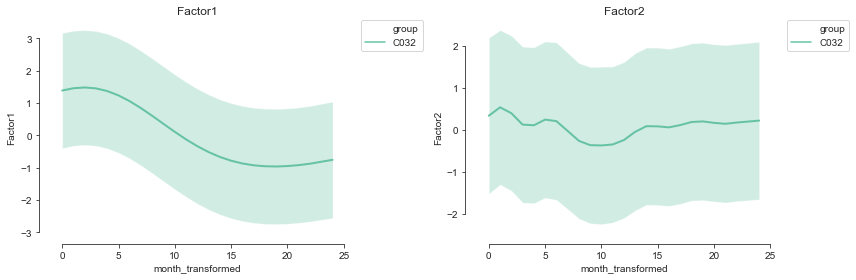

In [20]:
mofax.plot_interpolated_factors(m, groups=["C032"], size=70, only_mean=True);

mofax.plot_interpolated_factors(m, groups=["C032"], size=70, show_observed=False);

### Scatterplot

We can also look at the factor values on the sample level. Here each dot correspond to one time-point-child combination.

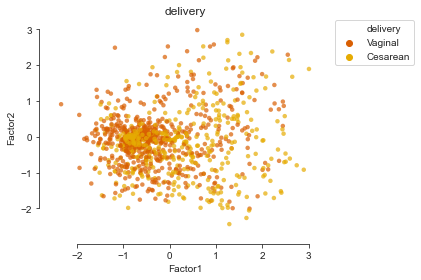

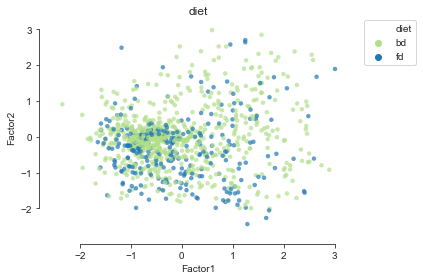

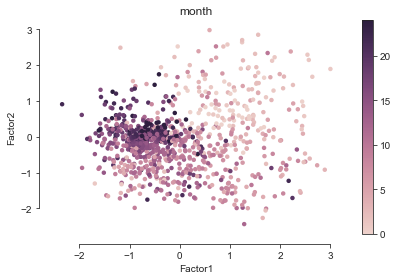

In [21]:
mofax.plot_factors(m, color="delivery", palette=cols4delivery, alpha=.7);
mofax.plot_factors(m, color="diet", palette=cols4diet, alpha=.7);
mofax.plot_factors(m, color="month", );

## Factor weights

Next we have a look at the microbial species associated with the factors, focusing on Factor 1. For this we have a look at the weights of the factor.

### Individual species

Let’s first have a look at the top positive and top negative species on factor 1. We find top negative weights for species of the genera Bacteroides and Faecalibacterium, meaning that their abundance varies in line with the negative of Factor 1, increasing over the first year of life and with higher abundance in vaginally delivered children.

In [22]:
m.get_weights(factors="Factor1", df=True).join(m.features_metadata).sort_values("Factor1").head()

,Factor1,view,Taxon,Confidence,kingdom,phylum,class,order,family,genus,species
c4f9ef34bd2919511069f409c25de6f1,-2.022511,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999160,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__
010f0ac2691bc0be12d0633d4b5d2cc4,-2.004185,microbiome,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.999978,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Faecalibacterium,s__prausnitzii
ac5402de1ddf427ab8d2b0a8a0a44f19,-1.911058,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999770,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__
40c85a458df8d5a935122ba778d4f334,-1.682951,microbiome,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.926572,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__
8937656c16c20701c107e715bad86732,-1.623216,microbiome,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.758990,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Roseburia,s__faecis


We can also take a look at the data for the top features on the factor:

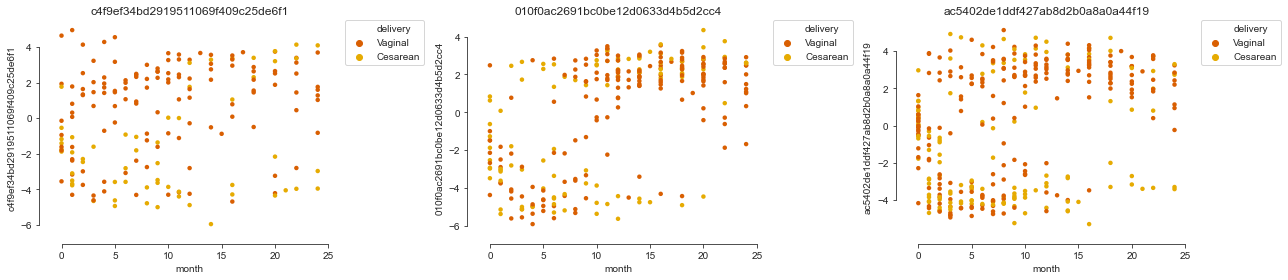

In [23]:
mofax.plot_factors(m, x="month", y=m.get_top_features(factors="Factor1", n_features=3), color="delivery", palette=cols4delivery);

### Aggregation to genus level

We now aggregate the weights on the genus level.

In [24]:
df_weights = (
    m.get_weights(df=True, factors="Factor1")
     .join(m.features_metadata)
     .query("genus != 'g__'")
)

df_weights.genus = df_weights.genus.str.replace('g__', '').str.replace('\\[', '').str.replace('\\]', '')

# summarize by mean weights across all species in the genus
# and filter to top 10 positive and negative ones
df_top = (
    df_weights
    .groupby("genus")
    .agg(mean_weight=("Factor1", "mean"),
         n_spec=("Factor1", "size"))
    .query("n_spec > 2")
    .reset_index()
    .assign(type=lambda x: np.where(x["mean_weight"] > 0, "Cesarean", "Vaginal"),
            mean_weight_abs=lambda x: np.abs(x["mean_weight"]))
    .groupby("type")
    .apply(lambda x: x.nlargest(5, "mean_weight_abs"))
    .sort_values("mean_weight", ascending=False)
    .reset_index(drop=1)
)

In [25]:
df_top

,genus,mean_weight,n_spec,type,mean_weight_abs
0,Coprobacillus,0.533045,4,Cesarean,0.533045
1,Peptoniphilus,0.344818,4,Cesarean,0.344818
2,Epulopiscium,0.322795,5,Cesarean,0.322795
3,Enterococcus,0.287105,5,Cesarean,0.287105
4,Dysgonomonas,0.273300,4,Cesarean,0.273300
5,Parabacteroides,-0.385500,9,Vaginal,0.385500
6,Paraprevotella,-0.455820,3,Vaginal,0.455820
7,Alistipes,-0.610057,4,Vaginal,0.610057
8,Bacteroides,-0.707119,25,Vaginal,0.707119
9,Faecalibacterium,-0.713432,9,Vaginal,0.713432


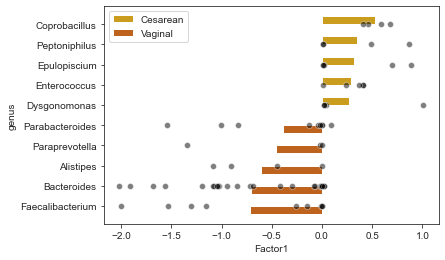

In [26]:
ax = sns.barplot(data=df_top, x="mean_weight", y="genus", hue="type", palette=cols4delivery)
sns.scatterplot(data=df_weights[df_weights.genus.isin(df_top.genus)].set_index("genus").loc[df_top.genus,:].reset_index(), 
                x="Factor1", y="genus", color="black", alpha=.5, ax=ax, zorder=10);

## Smoothness and sharedness of factors: Investigating the learnt hyper parameters

From the underlying Gaussian processes learnt by the model we can extract information on the smoothness of each factor, i.e. how smoothly it varies along time, as well as the sharedness of each factor, i.e. how much the children (groups) show the same underlying patterns and how they cluster based on the shape of their trajectory for a given microbial signature (captured in the weight of a factor).

### Smoothness score

The scale parameters of the Gaussian process capture the smoothness of the model. A scale of 1 indicates high smoothness, a scale of 0 variation independent of time. Here all factors show some but a rather low smoothness, indicating that there is a lot of noise and non-temporal variation in both factors.

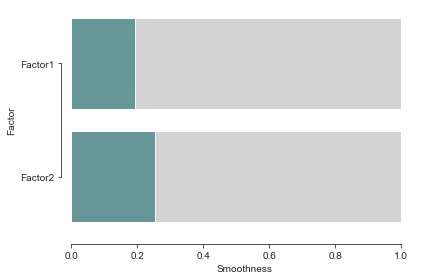

In [27]:
mofax.plot_smoothness(m);

### Sharedness

The group kernel of the Gaussian process can give us insights into the extent to which a temporal pattern captured on a factor is shared across children.

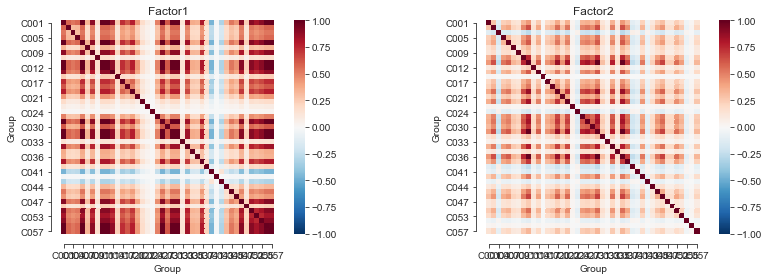

In [28]:
mofax.plot_group_kernel(m);

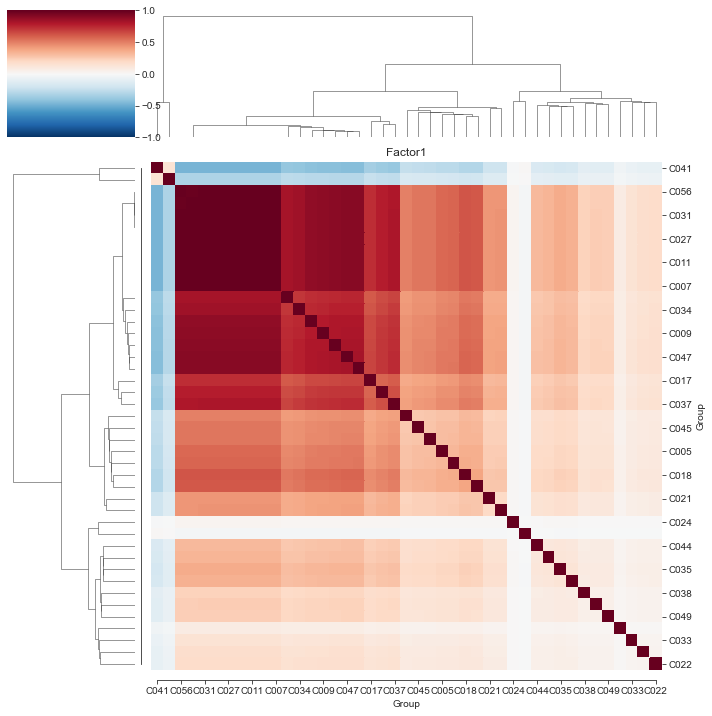

In [29]:
mofax.plot_group_kernel(m, factors=0);

For visualization we calculate an overall sharedness score per factor between 0 and 1. No color indicates no sharedness, a fully colored bar a fully shared factor.

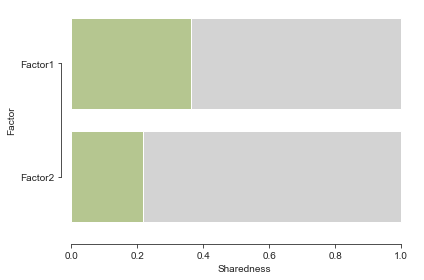

In [30]:
mofax.plot_sharedness(m);